In [1]:
from drought.visualization import plot
from drought.data import pipeline
import matplotlib.pyplot as plt
import pandas as pd
from drought.data.aggregator import get_monthly_means_and_shot_count
import drought.data.df_extensions as dfext
import drought.data.interpolate as interpolate
import seaborn as sns
from scipy.stats import norm
import numpy as np
from scipy.optimize import curve_fit
from math import exp

import importlib
importlib.reload(interpolate)

<module 'drought.data.interpolate' from '/home/jk871/drought-with-gedi/drought/data/interpolate.py'>

### Get all GEDI Footprints for 8 polygons

In [2]:
# Get GEDI footprints filtered by land use.
footprints = pipeline.get_filtered_gedi_footprints()
footprints

,Unnamed: 0,pai,rh100,pai_z,pavd_z,shot_number,lon_lowestmode,lat_lowestmode,l2b_quality_flag,geometry,year,month,polygon_id,polygon_spei
index,,,,,,,,,,,,,,
0,90,3.270860,1547,"[3.2708604, 2.1352415, 0.9860773, 0.034955956,...","[0.22712377, 0.22847831, 0.21002857, 0.0986077...",20420500100053124,-73.012176,-2.148434,1,POINT (-73.01217550938594 -2.148433601199582),2019,4,1,Y
1,92,0.226100,505,"[0.22610028, 0.0035991585, -0.0, -0.0, -0.0, -...","[0.044500224, 0.022610027, 0.00035991584, -0.0...",20420500100053126,-73.011580,-2.147593,1,POINT (-73.01158014712219 -2.147592765811703),2019,4,1,Y
2,104,0.796234,771,"[0.7962339, 0.22036836, -0.0, -0.0, -0.0, -0.0...","[0.11517311, 0.07962339, 0.022036836, -0.0, -0...",20420500100053090,-73.022286,-2.162795,1,POINT (-73.02228628616268 -2.162794720210879),2019,4,1,Y
3,111,1.732929,1515,"[1.7329292, 1.3658544, 0.76820797, 0.013168488...","[0.07341496, 0.09647212, 0.13526858, 0.0768208...",21490600100274710,-72.754148,-1.163992,1,POINT (-72.7541482465911 -1.1639923700881025),2019,4,1,Y
4,112,1.270815,955,"[1.2708149, 0.6544391, -0.0, -0.0, -0.0, -0.0,...","[0.12327517, 0.12708148, 0.06544391, -0.0, -0....",21490600100274708,-72.754743,-1.164835,1,POINT (-72.75474328953197 -1.1648345603875192),2019,4,1,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16396666,21557,2.853983,2557,"[2.849689, 2.3801837, 1.2133926, 0.41105875, 0...","[0.09390106, 0.16362964, 0.1969125, 0.10866271...",197430800400540951,-40.906305,-16.091858,1,POINT (-40.906305431560064 -16.091857723217107),2022,6,8,N
16396667,21558,4.018536,2520,"[4.0185356, 2.936548, 1.5955708, 0.62926304, 0...","[0.21639751, 0.24229647, 0.23072849, 0.1392814...",197430800400540952,-40.905988,-16.092262,1,POINT (-40.90598776363747 -16.092261576462985),2022,6,8,N
16396669,21560,2.900666,1897,"[2.9003391, 1.9306061, 0.6197635, 0.08393921, ...","[0.19394659, 0.22805755, 0.1846667, 0.06197635...",197430800400540954,-40.905351,-16.093070,1,POINT (-40.905351479888324 -16.093070060454053),2022,6,8,N


In [ ]:
footprints = dfext.add_date_column(footprints)

In [ ]:
# Filter footprints based on height. rh100 - 500cm = 5m
footprints = footprints[footprints.rh100 > 500]

### GEDI Availability

In [ ]:
def get_gedi_monthly(gedi_footprints):
    monthly = get_monthly_means_and_shot_count(gedi_footprints, columns=['pai', 'rh100'])
    monthly = interpolate.fill_timeseries_missing_data(monthly, 
                                                   start_date='04-2019', 
                                                   end_date='07-2022', 
                                                   values_to_fill={'number': 0})
    monthly= dfext.add_date_column(monthly)
    return monthly

In [ ]:
monthly = get_gedi_monthly(footprints)

In the plot below, we plot the number of GEDI shots for that month vs. the mean PAI value for the month. If there are no GEDI shots for the entire month, we will have missing PAI data. We can see in the plot the missing data where the orange line has the breaks in.

Polygon 3 misses a lot of months in 2020, and Polygon 1 is missing 2 months in total. The rest of the polygons have non-zero shots for each month.

We can note as well that value of PAI in some months is out of line with the PAI values in the adjacent months. These usually correlate with months in which we have fewer GEDI shots. Some obvious outliers are:
* Polygon 1
  *  10-2020
* Polygon 2
  * 04-2019
  * 12-2019
  * 04-2020
* Polygon 3 - many, and much data is missing
* Polygon 4
  * 04-2020
  * 06-2022
* Polygon 5
  * 11-2019
  * 03-2020
* Polygon 6
  * 06-2022
* Polygon 7
  * 07-2020
  * 05-2021
* Polygon 8
  * 03-2020
  * 01-2021
  

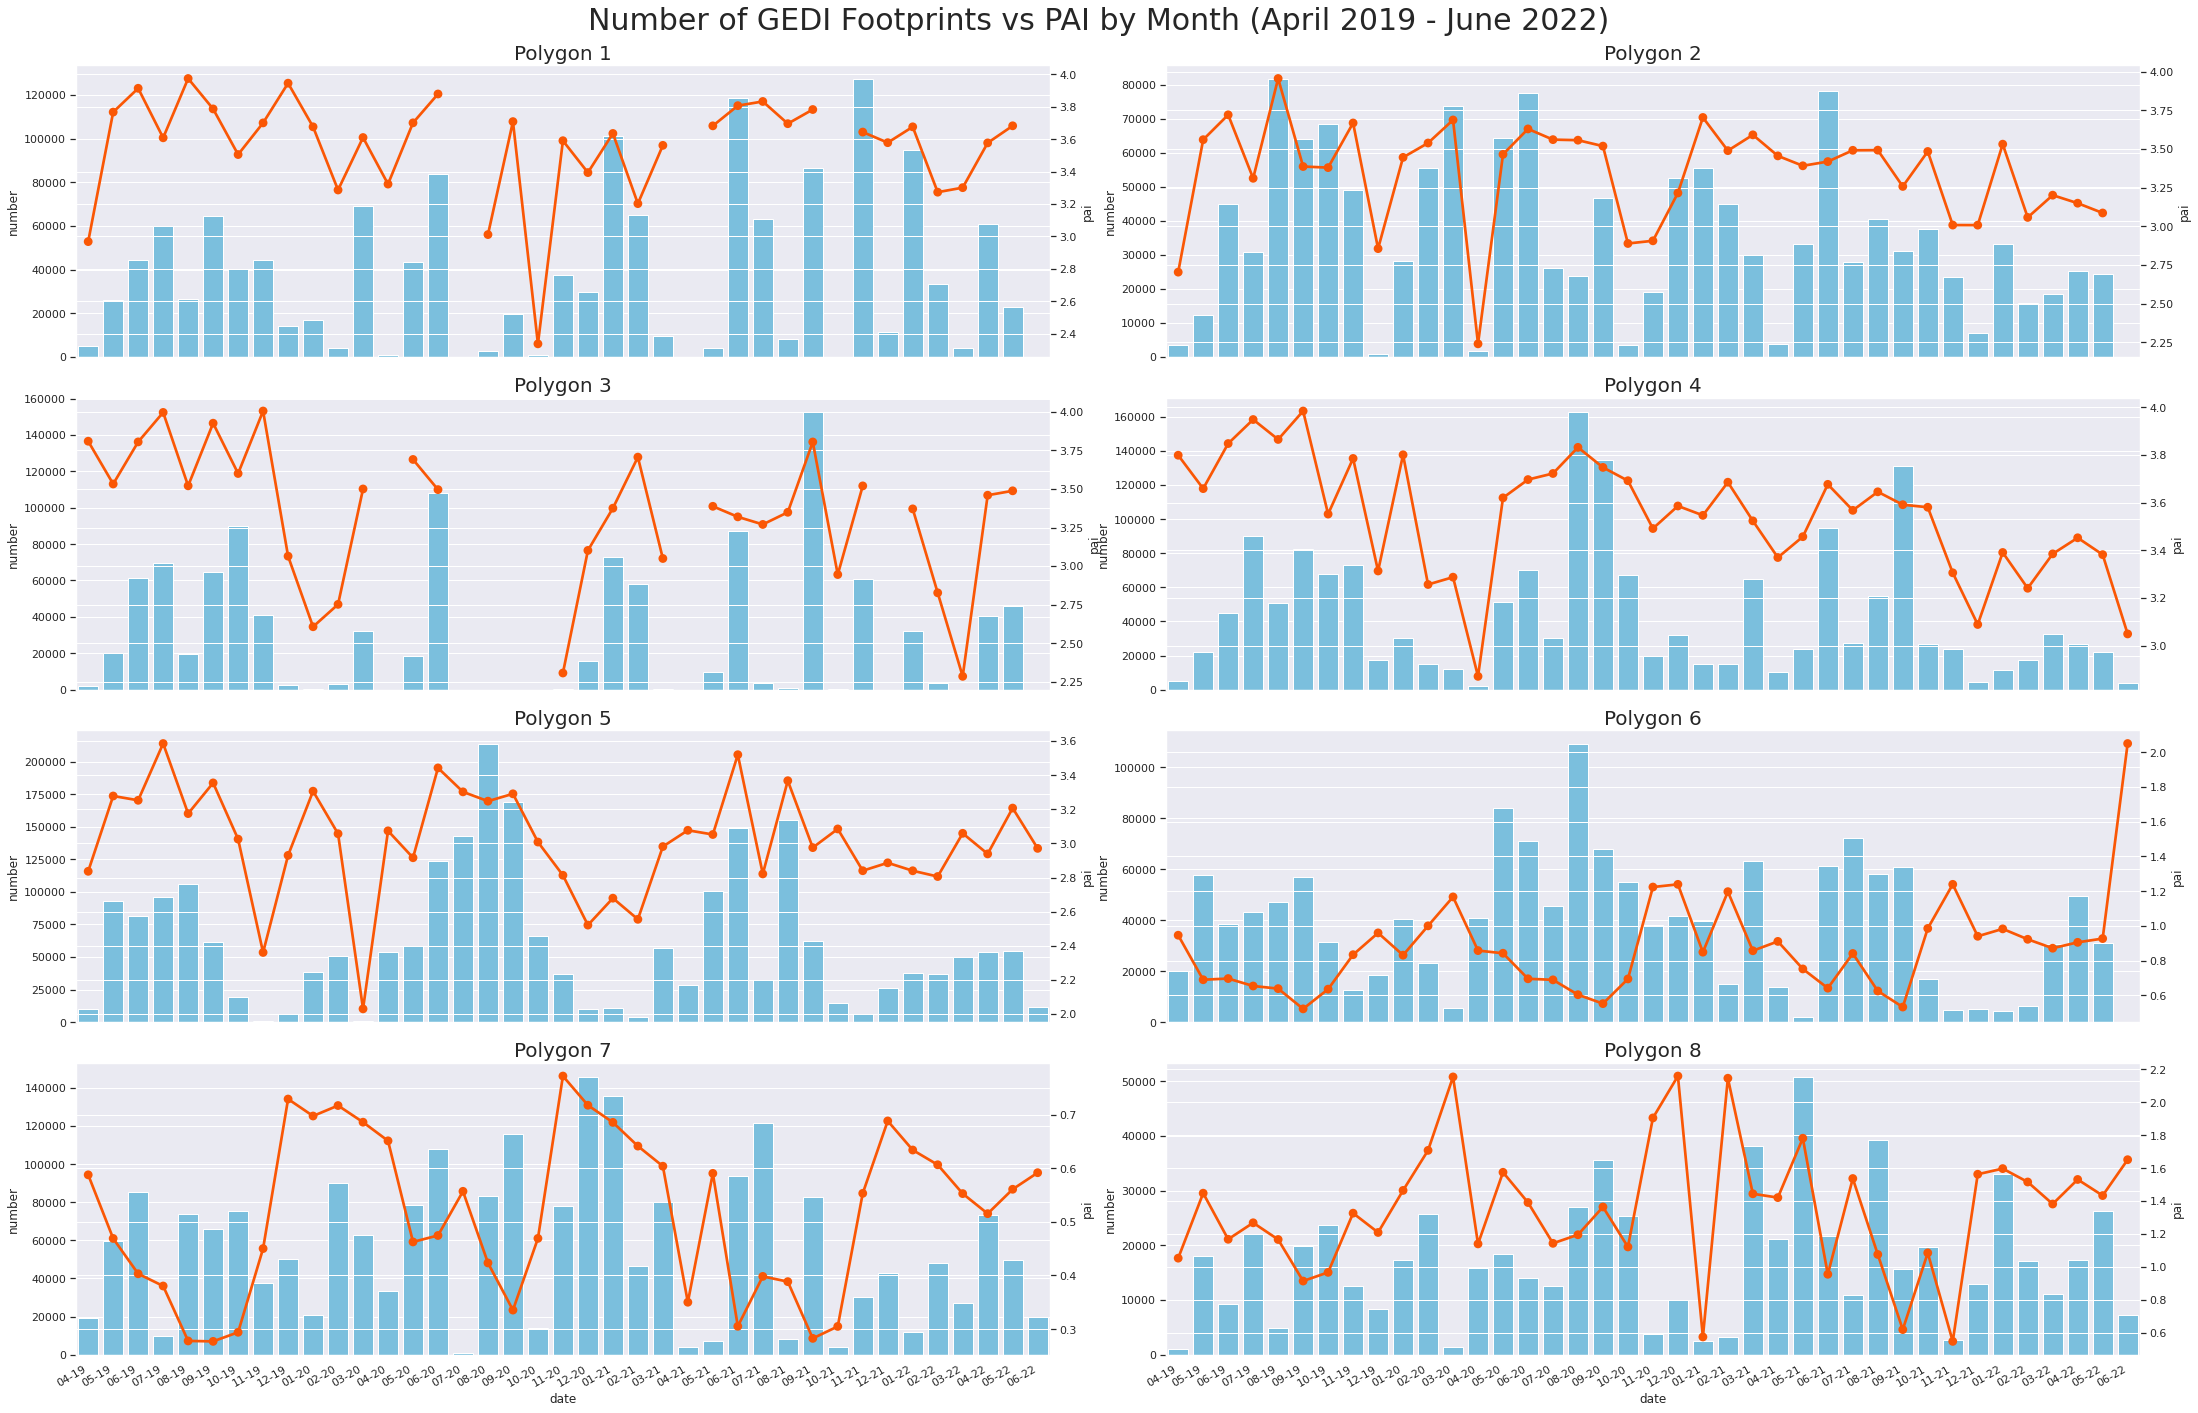

In [254]:
fig, ax = plot.layered_plot_per_polygon(monthly, 
                                        x='date',
                                        bar_y='number',
                                        line_y='pai',
                                        title="Number of GEDI Footprints vs PAI by Month (April 2019 - June 2022)") # noqa: E501

fig.autofmt_xdate()

### Get only GEDI Footprints for months that have more than 6000 samples

In [337]:
# Keep only months that have more than 6000 samples
monthly_filtered = get_gedi_monthly(footprints)
monthly_filtered.loc[monthly_filtered.number < 6000, 'pai'] = np.nan
monthly_filtered.loc[monthly_filtered.number < 6000, 'rh100'] = np.nan
monthly_filtered.loc[monthly_filtered.number < 6000, 'number'] = np.nan
monthly_filtered

,pai,rh100,year,month,polygon_id,number,date
0,NaN,NaN,2019,4,1,NaN,04-19
1,NaN,NaN,2019,4,2,NaN,04-19
2,NaN,NaN,2019,4,3,NaN,04-19
3,NaN,NaN,2019,4,4,NaN,04-19
4,2.843454,2559.252232,2019,4,5,9967.0,04-19
...,...,...,...,...,...,...,...
297,0.673249,911.131269,2022,6,7,17049.0,06-22
298,1.691554,1511.920365,2022,6,8,7007.0,06-22
302,NaN,NaN,2022,6,1,NaN,06-22
303,NaN,NaN,2022,6,2,NaN,06-22


In [338]:
monthly_interpolated = interpolate.interpolate_using_weighted_average(monthly_filtered.fillna(0), weight='number', value='pai').replace(0, np.nan)
#monthly_interpolated = interpolate.interpolate_using_weighted_average(monthly_interpolated, weight='number', value='rh100')

In [331]:
monthly_interpolated.to_csv("../../data/interim/gedi_monthly_interpolated_via_weighted_average_excluding_months_with_less_than_6000_shots.csv")

In [342]:
monthly_new_interpol = pd.read_csv("../../data/interim/gedi_monthly_interpolated_via_weighted_average_excluding_months_with_less_than_6000_shots.csv", index_col=0)

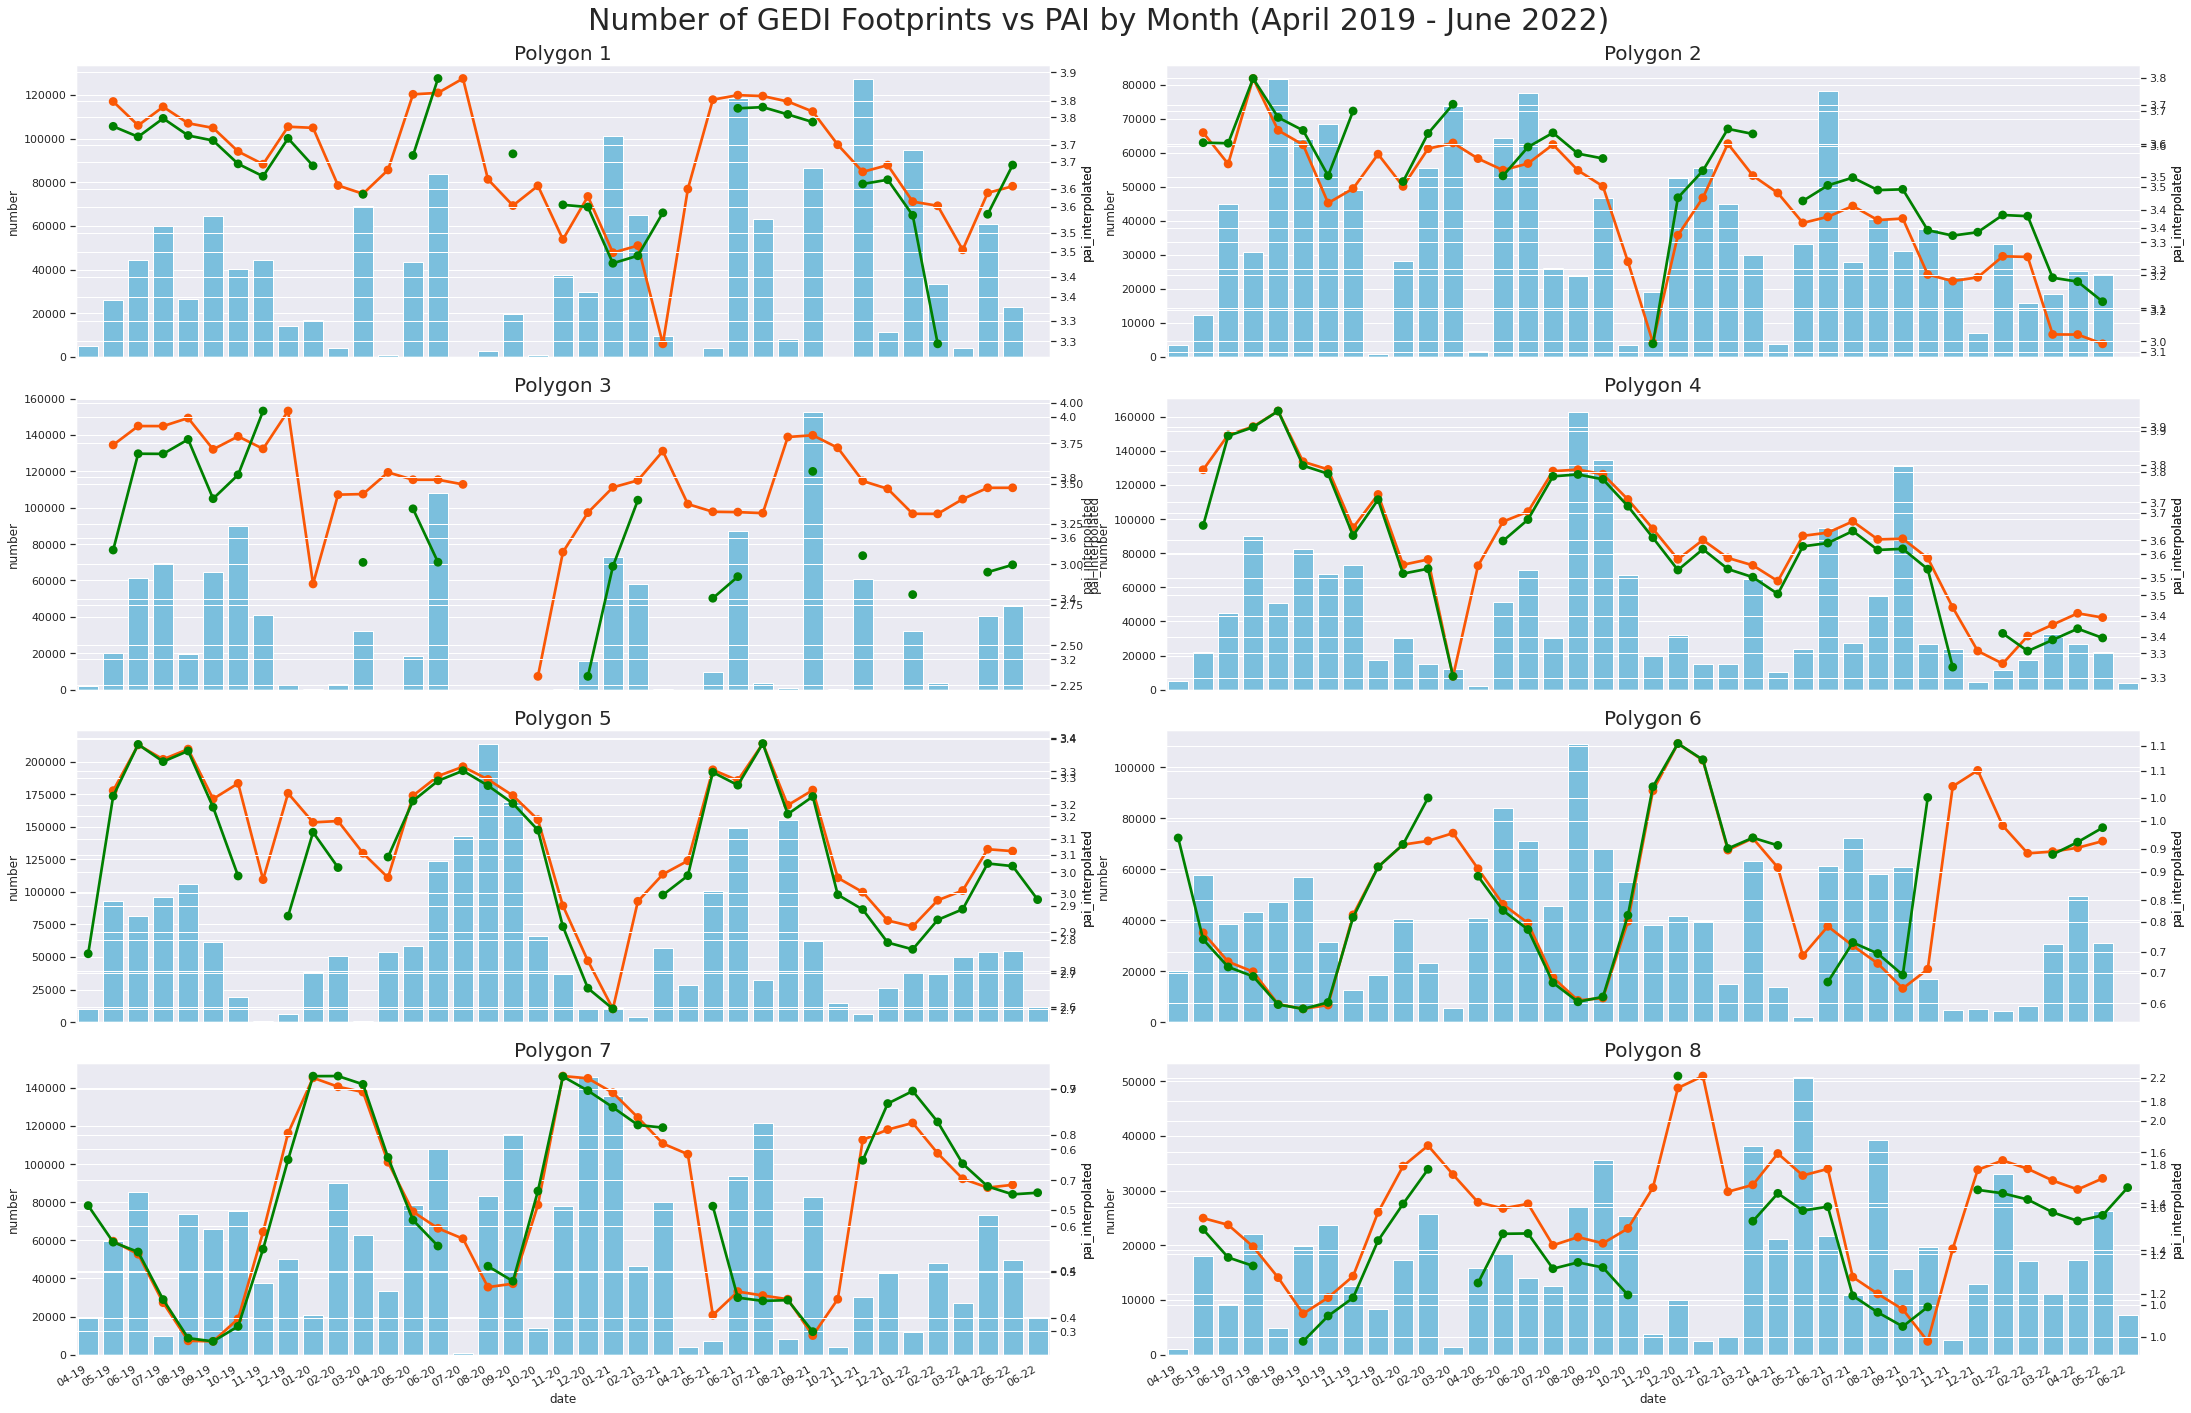

In [344]:
fig, ax = plot.layered_plot_per_polygon(monthly_old_interpolation, 
                                        x='date',
                                        bar_y='number',
                                        line_y='pai_interpolated',
                                        title="Number of GEDI Footprints vs PAI by Month (April 2019 - June 2022)") # noqa: E501

# Plot PAI on top that wasn't filtered by the land use.
for i in range(8):
    subplot = ax[i // 2, i % 2]

    # Select polygon from the data. Polygon IDs go from 1 to 8.
    polygon_id = i + 1
    polygon_data = monthly_new_interpol[monthly_new_interpol['polygon_id'] == polygon_id]

    # Line plot on top.
    pai_subplot = subplot.twinx()
    sns.pointplot(polygon_data, x='date', y='pai_interpolated', color='green',
                ax=pai_subplot)
fig.autofmt_xdate()

fig.autofmt_xdate()

In [340]:
monthly_old_interpolation = pd.read_csv("../../data/interim/gedi_monthly_interpolated_via_weighted_average.csv", index_col=0)

### Fit GEDI data

In [ ]:
monthly_filtered.loc[monthly_filtered.number < 6000, 'pai'] = np.nan

### Polygon 1

In [ ]:
def fit_function(x, A, beta, B, mu, sigma):
    return (A * np.exp(-x/beta) + B * np.exp(-1.0 * (x - mu)**2 / (2 * sigma**2)))

In [ ]:
def fit_gauss(x, B, mu, sigma):
    return B * np.exp(-1.0 * (x - mu)**2 / (2 * sigma**2))

In [ ]:
def get_one_month_data(df, polygon_id, month, year):
    return df.loc[(df.polygon_id == polygon_id)&(df.month==month)&(df.year==year)]

In [ ]:
def fit_gaussian_and_plot(df, polygon_id, month, year):
    one_month_data = get_one_month_data(df, polygon_id, month, year).pai
    if (one_month_data.shape[0] == 0):
        print(f'No data for {month} and {year}')
        return
    
    print("Before: " + str(one_month_data.mean()))
    bins = np.linspace(0, 10, 100)
    data_entries, bins = np.histogram(one_month_data, bins=bins)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

    mu, std = norm.fit(one_month_data)
    #popt, pcov = curve_fit(fit_function, xdata=binscenters, ydata=data_entries, p0=[20000, 2.0, 2000, 3.0, 0.3])
    print("After: " + str(mu))

    # Plot the histogram.
    plt.hist(one_month_data, bins=100, density=True, alpha=0.6, color='g')

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)

    plt.show()

In [ ]:
def fit_exponential_gaussian_and_plot(df, polygon_id, month, year, plot=False):
    one_month_data = get_one_month_data(df, polygon_id, month, year).pai
    if (one_month_data.shape[0] == 0):
        #print(f'No data for {month} and {year}')
        return
    
    #print("Before: " + str(one_month_data.mean()))
    bins = np.linspace(0, 10, 200)
    data_entries, bins = np.histogram(one_month_data, bins=bins)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

    try:
        popt, pcov = curve_fit(fit_function, xdata=binscenters, ydata=data_entries, p0=[100, 2.0, 500, 4.0, 0.3])
        #print("After: " + str(popt[3]))
    except:
        print(f'{polygon_id} {month} {year}')
        print('Could not fit the month!')
        return None

    if not plot:
        return popt[3]
    # plot
    xspace = np.linspace(0, 10, 100000)

    # Plot the histogram and the fitted function.
    plt.bar(binscenters, data_entries, width=bins[1] - bins[0], color='navy', label=r'Histogram entries')
    plt.plot(xspace, fit_function(xspace, *popt), color='darkorange', linewidth=2.5, label=r'Fitted function')

    # Make the plot nicer.
    plt.xlim(0,10)
    plt.xlabel(r'x axis')
    plt.ylabel(r'Number of entries')
    plt.title(r'Exponential decay with gaussian peak')
    plt.legend(loc='best')
    plt.show()
    plt.clf()
    return popt[3]

In [ ]:
new_data = {}

In [ ]:
new_data['3_3_2022'] = [3, 2022, 3, get_one_month_data(footprints, 3, 3, 2022).pai.mean()]

In [ ]:
# Plot all months for a given year and a given polygon
for polygon_id in range(1, 6):
    for year in range(2019, 2023):
        for month in range(1, 13):
            pai = fit_exponential_gaussian_and_plot(footprints, polygon_id, month, year)
            if pai is not None:
                new_data[f'{polygon_id}_{month}_{year}'] = [polygon_id, year, month, pai]

In [ ]:
# Plot all months for a given year and a given polygon
for polygon_id in range(6, 9):
    for year in range(2019, 2023):
        for month in range(1, 13):
            new_data[f'{polygon_id}_{month}_{year}'] = [polygon_id, year, month, get_one_month_data(footprints, polygon_id, month, year).pai.mean()]

In [ ]:
monthly = pd.DataFrame.from_dict(new_data, orient='index', columns=['polygon_id', 'year', 'month', 'pai'])

In [ ]:
monthly

In [ ]:
import drought.data.df_extensions as dfext
monthly = dfext.add_date_column(monthly)
monthly

In [ ]:
monthly.to_csv('../../data/interim/gedi_PAI_fitted_monthly.csv')

In [ ]:
list_of_outliers = [(1, 10, 2020), (2, 4, 2019), (2, 12, 2019), (2, 4, 2020), (2, 10, 2020), (2, 11, 2020), (3, 12, 2019), (3, 11, 2020), (3, 3, 2022), (4, 10, 2019), (4, 12, 2019), (4, 4, 2020), (4, 4, 2021), (4, 6, 2022), (5, 11, 2019), (5, 3, 2020)]

In [ ]:
for (polygon_id, month, year) in list_of_outliers:
    print(f'{polygon_id} {month} {year}')
    fit_exponential_gaussian_and_plot(footprints, polygon_id, month, year, plot=True)

In [ ]:
original_monthly = footprints.groupby(['polygon_id', 'month', 'year']).mean().reset_index()

In [ ]:
original_monthly = dfext.add_date_column(original_monthly)

In [ ]:
list_of_outliers = [(1, 10, 2020), (2, 12, 2019), (2, 4, 2019), (2, 4, 2020), (2, 10, 2020), (2, 11, 2020), (3, 3, 2022), (4, 9, 2021), (4, 2, 2022), (5, 11, 2020), (5, 9, 2021), (5, 11, 2021), (5, 2, 2022)]

In [ ]:
plt.rcParams['figure.figsize'] = [30, 12]
sns.pointplot(monthly[monthly.polygon_id == 5], x='date', y='pai')
sns.pointplot(original_monthly[original_monthly.polygon_id == 5], x='date', y='pai', color='orangered')

In [ ]:
fit_gaussian_and_plot(footprints, 3, 1, 2020)

In [ ]:
# Plot all months for a given year and a given polygon
year = 2019
for month in range(1, 13):
    fit_gaussian_and_plot(footprints, 1, month, year)

In [ ]:
# Plot all months for a given year and a given polygon
year = 2020
for month in range(1, 13):
    fit_exponential_gaussian_and_plot(footprints, 1, month, year)

In [ ]:
plt.hist(one_month_data.pai, bins=100, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [ ]:
one_month_data.shape[0]

### Analyze individual months

In [ ]:
def plot_monthly_time_series(df, polygon_id):
    fig, ax = plt.subplots(2, 1, figsize=(25, 10))
    fig.suptitle(f'Polygon monthly mean timeseries {polygon_id}', fontsize=20)

    polygon_data = df.loc[(df.polygon_id == polygon_id)]
    
    # Take monthly means
    #monthly_means = polygon_data.groupby(['year', 'month', 'date']).mean().reset_index()

    #sns.barplot(polygon_data, x='date', y='number', color='#6BC5ED', ax=ax[0])
    
    sns.pointplot(polygon_data, x='date', y='rh100', ax=ax[1])

    #bar_ax = ax[0].twinx()
    sns.pointplot(polygon_data, x='date', y='pai', ax=ax[0], color='#FA5705')
    fig.autofmt_xdate()
    plt.show()


In [ ]:
def plot_one_month_data(df, polygon_id, month, year, pai_x_lim_max=6, pai_threshold=0.1):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Footprints for polygon {polygon_id}. Date: {month}-{year}', fontsize=20)

    polygon = df.loc[(df.polygon_id == polygon_id)]
    one_month = df.loc[(df.polygon_id == polygon_id)&(df.month==month)&(df.year==year)]
    if (one_month is None):
        return
    one_month_low_pai = one_month[one_month.pai < pai_threshold]

    # Plot lidar traces on lon-lat map.
    sns.scatterplot(x=one_month.lon_lowestmode, y=one_month.lat_lowestmode, ax=ax[0])
    sns.scatterplot(x=one_month_low_pai.lon_lowestmode, y=one_month_low_pai.lat_lowestmode, ax=ax[0], color='red')
    ax[0].set_xlim(polygon.lon_lowestmode.min(), polygon.lon_lowestmode.max())
    ax[0].set_ylim(polygon.lat_lowestmode.min(), polygon.lat_lowestmode.max())

    # Plot pai.
    sns.histplot(one_month.pai, ax=ax[1], binrange=(0,6), bins=30)
    ax[1].set_xlim(0, pai_x_lim_max)
    sns.histplot(one_month_low_pai.pai, ax=ax[1], color='red', binrange=(0,6), bins=30)
    ax[1].set_xlim(0, pai_x_lim_max)
    
    ax[1].axvline(one_month.pai.mean(), c='red', ls='-', lw=2.5)
    ax[1].axvline(one_month.pai.median(), c='orange', ls='--', lw=2.5)

    # Plot rh100.
    sns.histplot(one_month.rh100, ax=ax[2], binrange=(0, 6000), bins=30)
    sns.histplot(one_month_low_pai.rh100, ax=ax[2], color='red', binrange=(0, 6000), bins=30)

    plt.show()
    return one_month

### Polygon 1

In [ ]:
plt.rcParams['figure.figsize'] = [25, 5]
sns.barplot(monthly[(monthly.polygon_id==1)], x='month', y='number')
fig.autofmt_xdate()

In [ ]:
plt.rcParams['figure.figsize'] = [25, 5]
sns.barplot(monthly[(monthly.polygon_id==1)], x='date', y='number')
fig.autofmt_xdate()

In [ ]:
plot_monthly_time_series(footprints, 1)

In [ ]:
# Plot all months for a given year and a given polygon
year = 2022
for month in range(1, 13):
    print(month)
    print(plot_one_month_data(footprints, 1, month, year, pai_threshold=0.2).shape)

### Polygon 2

In [ ]:
plt.rcParams['figure.figsize'] = [25, 5]
sns.barplot(monthly[(monthly.polygon_id==2)], x='month', y='number')
fig.autofmt_xdate()

In [ ]:
plt.rcParams['figure.figsize'] = [25, 5]
sns.barplot(monthly[(monthly.polygon_id==2)], x='date', y='number')
fig.autofmt_xdate()

In [ ]:
plot_monthly_time_series(footprints, 2)

In [ ]:
# Plot all months for a given year and a given polygon
year = 2022
for month in range(1, 13):
    print(month)
    print(plot_one_month_data(footprints, 2, month, year, pai_threshold=0.2).shape)

### Polygon 3

In [ ]:
plt.rcParams['figure.figsize'] = [25, 5]
sns.barplot(monthly[(monthly.polygon_id==3)], x='month', y='number')
fig.autofmt_xdate()

In [ ]:
plt.rcParams['figure.figsize'] = [25, 5]
sns.barplot(monthly[(monthly.polygon_id==3)], x='date', y='number')
fig.autofmt_xdate()

In [ ]:
plot_monthly_time_series(footprints, 3)

In [ ]:
# Plot all months for a given year and a given polygon
year = 2022
for month in range(1, 13):
    print(month)
    print(plot_one_month_data(footprints, 3, month, year, pai_threshold=0.2).shape)

### Polygon 4

In [ ]:
plt.rcParams['figure.figsize'] = [25, 5]
sns.barplot(monthly[(monthly.polygon_id==4)], x='month', y='number')
fig.autofmt_xdate()

In [ ]:
plt.rcParams['figure.figsize'] = [25, 5]
sns.barplot(monthly[(monthly.polygon_id==4)], x='date', y='number')
fig.autofmt_xdate()

In [ ]:
plot_monthly_time_series(footprints, 4)

In [ ]:
# Plot all months for a given year and a given polygon
year = 2022
for month in range(1, 13):
    print(month)
    print(plot_one_month_data(footprints, 4, month, year, pai_threshold=0.2).shape)

### Polygon 5

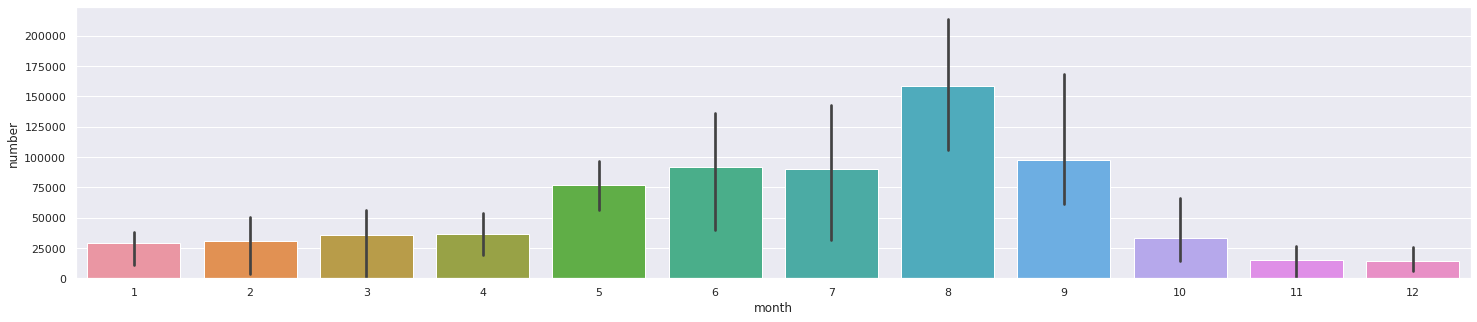

In [245]:
plt.rcParams['figure.figsize'] = [25, 5]
sns.barplot(monthly[(monthly.polygon_id==5)], x='month', y='number')
fig.autofmt_xdate()

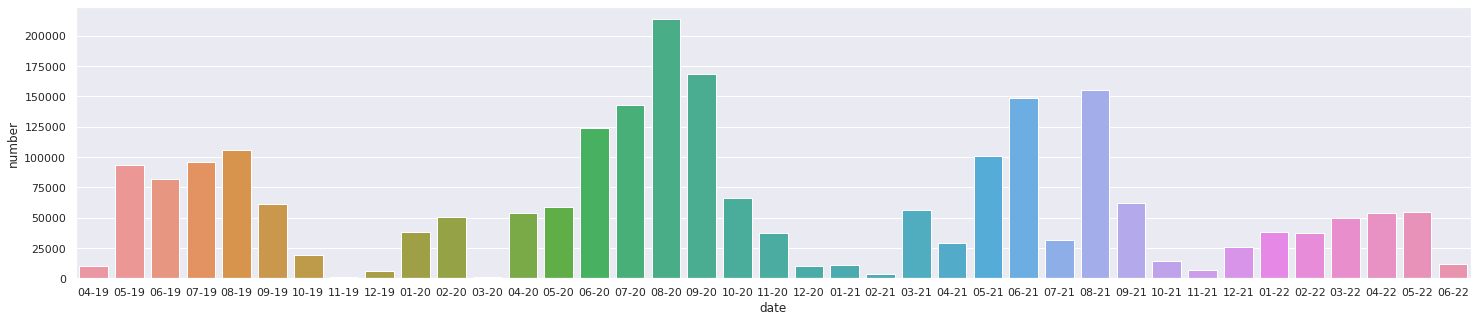

In [246]:
plt.rcParams['figure.figsize'] = [25, 5]
sns.barplot(monthly[(monthly.polygon_id==5)], x='date', y='number')
fig.autofmt_xdate()

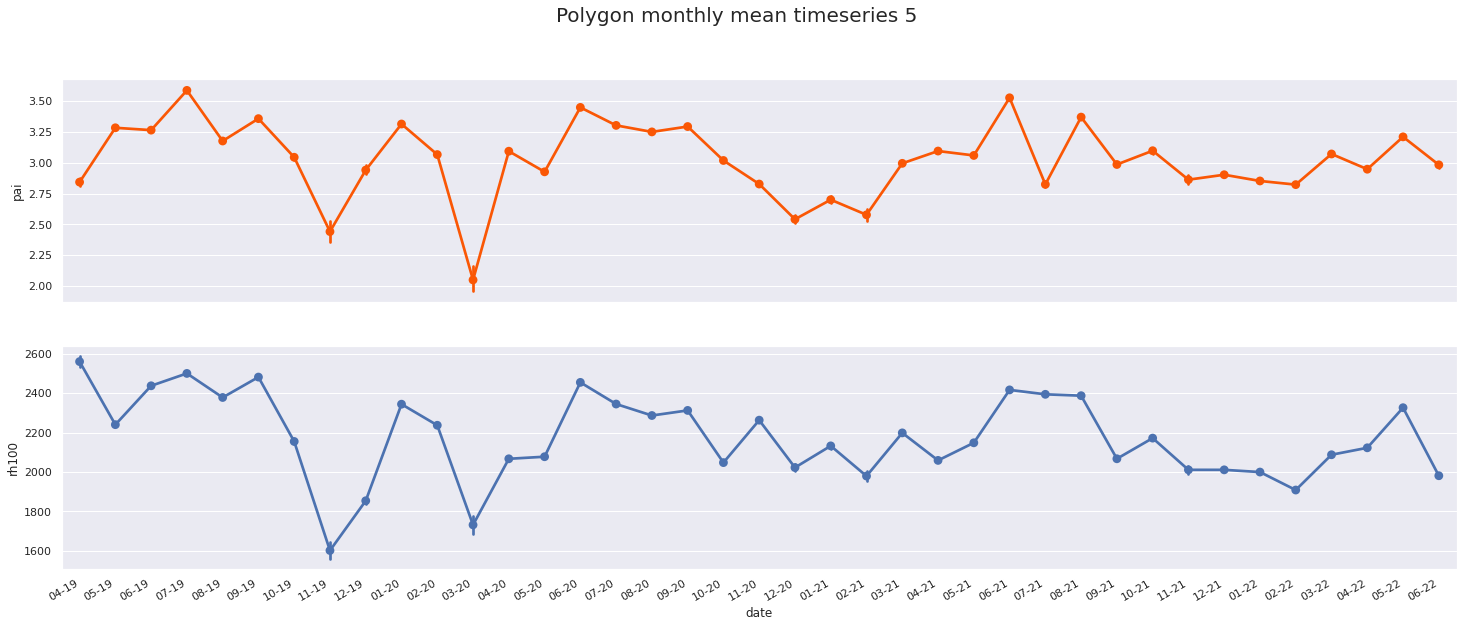

In [247]:
plot_monthly_time_series(footprints, 5)

1


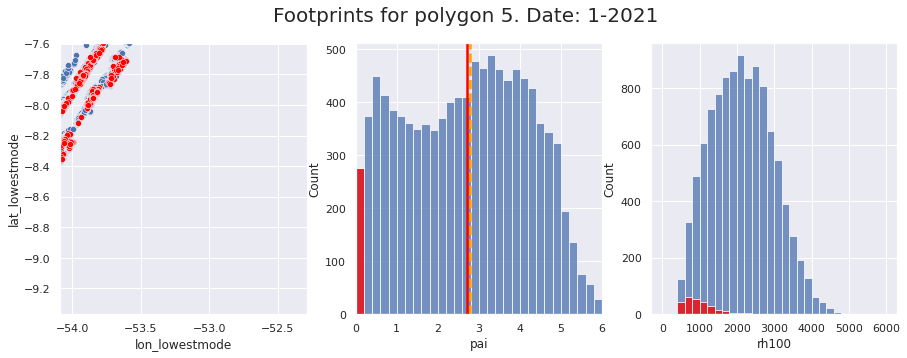

(10514, 15)
2


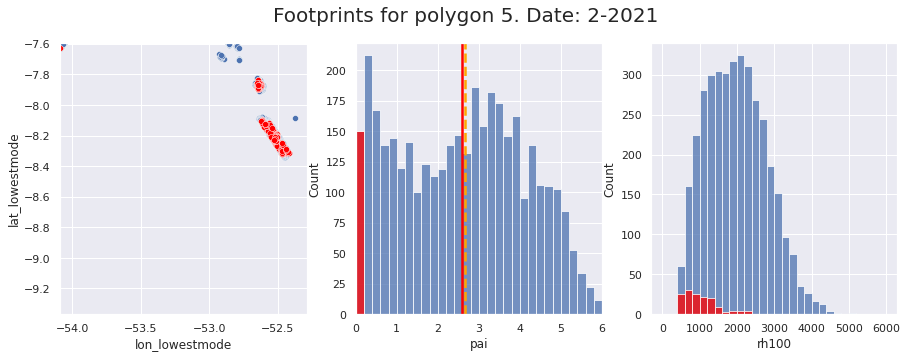

(3708, 15)
3


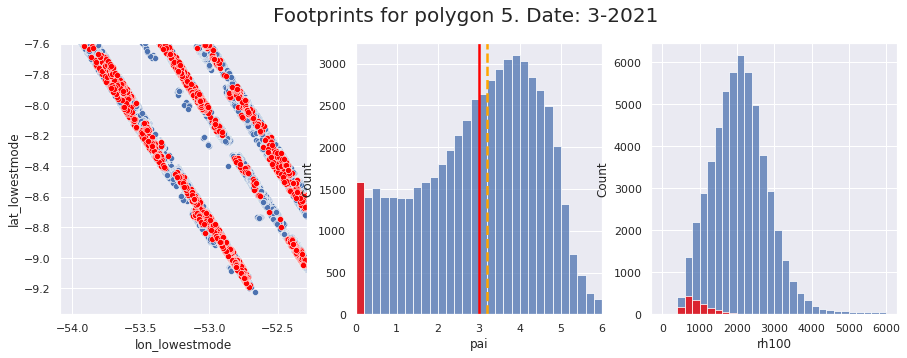

(56423, 15)
4


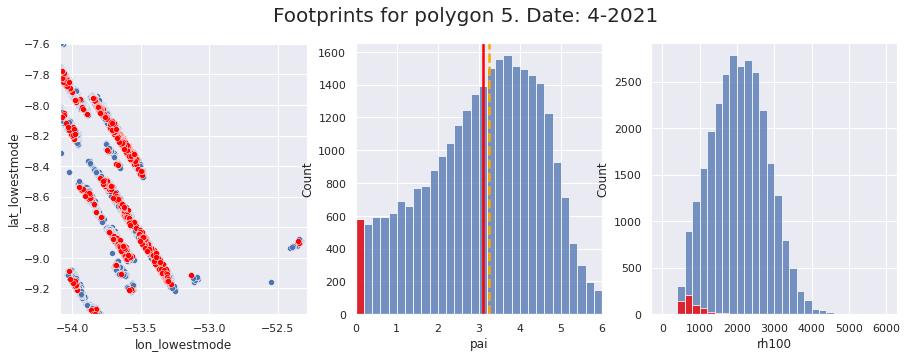

(28533, 15)
5


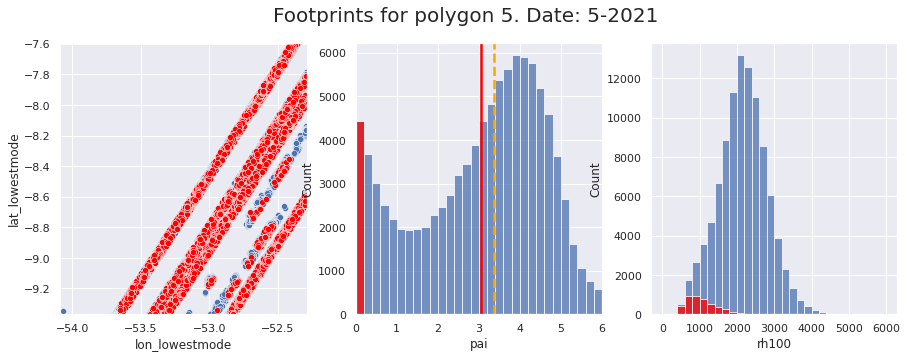

(100508, 15)
6


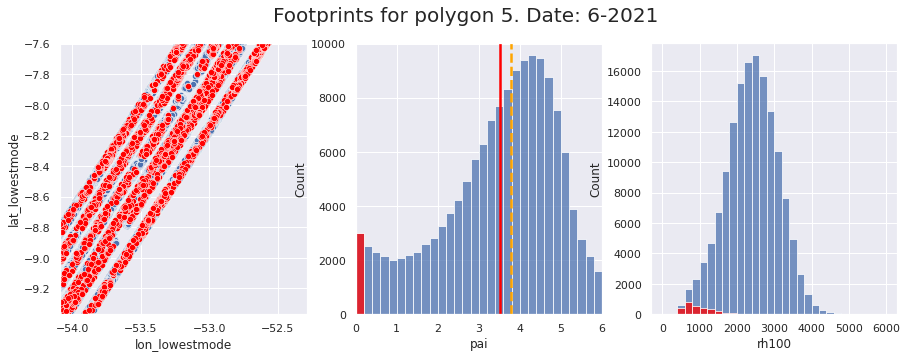

(148519, 15)
7


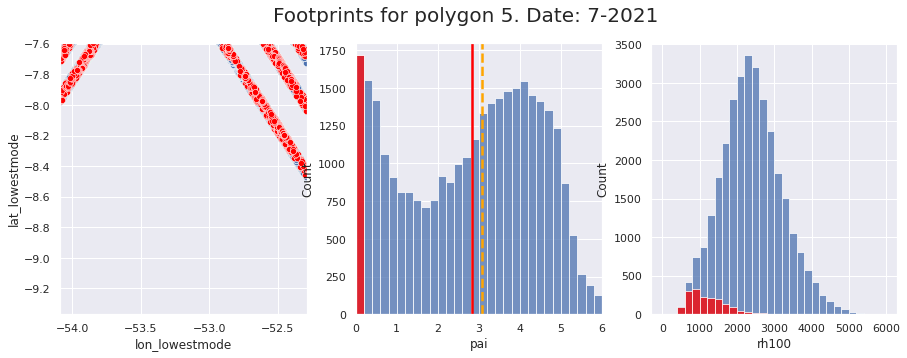

(31931, 15)
8


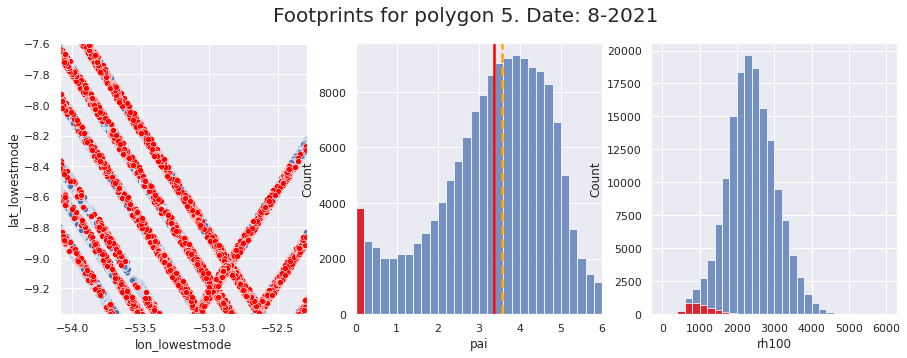

(155241, 15)
9


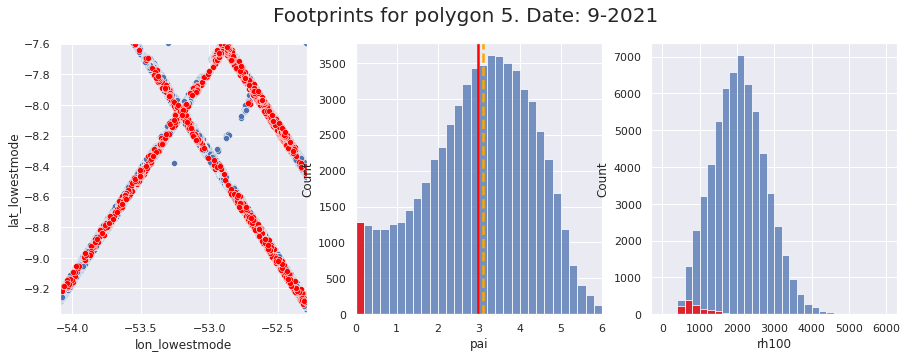

(61945, 15)
10


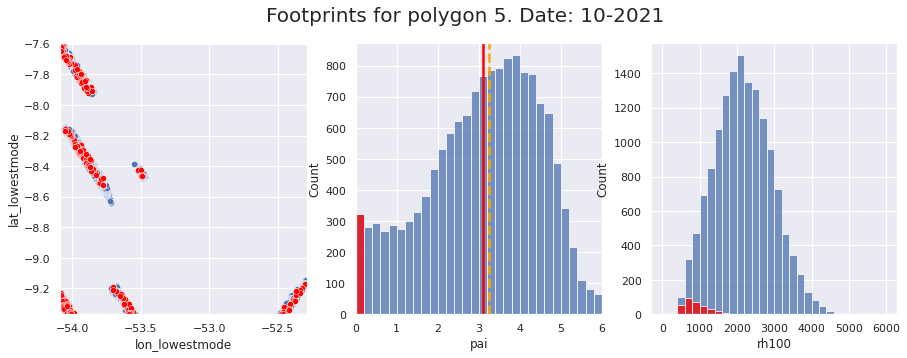

(14562, 15)
11


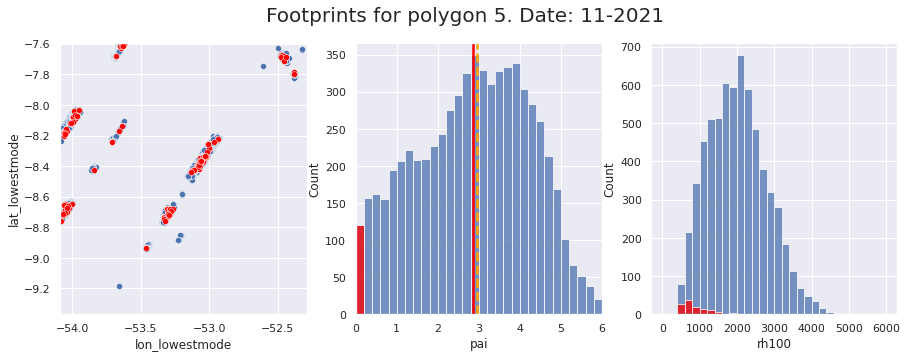

(6523, 15)
12


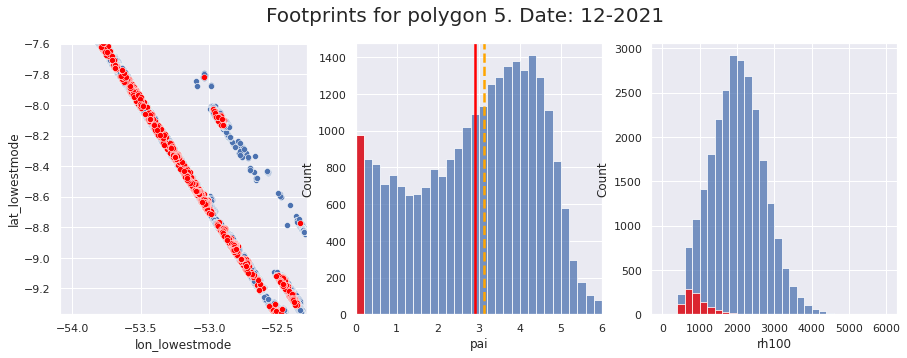

(25925, 15)


In [253]:
# Plot all months for a given year and a given polygon
year = 2021
for month in range(1, 13):
    print(month)
    print(plot_one_month_data(footprints, 5, month, year, pai_threshold=0.2).shape)

## Compare GEDI shots filtered with Land Use filter vs. minimally filtered 

In [ ]:
PATH_TO_FILTERED_GEDI = '/maps/drought-with-gedi/gedi_data/gedi_shots_level_2b_land_filtered.csv'
filtered_footprints = pd.read_csv(PATH_TO_FILTERED_GEDI, index_col=0)

In [ ]:
filtered_monthly = get_monthly_means_and_shot_count(filtered_footprints, columns=['pai', 'rh100'])

In [ ]:
filtered_monthly = interpolate.fill_timeseries_missing_data(filtered_monthly,
                                                            start_date='04-2019', 
                                                            end_date='07-2022', 
                                                            values_to_fill={'number': 0})

In [ ]:
filtered_monthly= dfext.add_date_column(filtered_monthly)

In [ ]:
fig, ax = plot.layered_plot_per_polygon(filtered_monthly, 
                                        x='date',
                                        bar_y='number',
                                        line_y='pai',
                                        title="GEDI PAI minimally filtered (orange) vs. land use filterd (green) (April 2019 - June 2022)") # noqa: E501


# Plot PAI on top that wasn't filtered by the land use.
for i in range(8):
    subplot = ax[i // 2, i % 2]

    # Select polygon from the data. Polygon IDs go from 1 to 8.
    polygon_id = i + 1
    polygon_data = monthly[monthly['polygon_id'] == polygon_id]

    # Line plot on top.
    pai_subplot = subplot.twinx()
    sns.pointplot(polygon_data, x='date', y='pai', color='green',
                ax=pai_subplot)
fig.autofmt_xdate()

In [ ]:
fig, ax = plot.layered_plot_per_polygon(filtered_monthly, 
                                        x='date',
                                        bar_y='number',
                                        line_y='rh100',
                                        title="GEDI PAI minimally filtered (orange) vs. land use filterd (green) (April 2019 - June 2022)") # noqa: E501


# Plot PAI on top that wasn't filtered by the land use.
for i in range(8):
    subplot = ax[i // 2, i % 2]

    # Select polygon from the data. Polygon IDs go from 1 to 8.
    polygon_id = i + 1
    polygon_data = monthly[monthly['polygon_id'] == polygon_id]

    # Line plot on top.
    pai_subplot = subplot.twinx()
    sns.pointplot(polygon_data, x='date', y='rh100', color='green',
                ax=pai_subplot)
fig.autofmt_xdate()